In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class CNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_net = CNNNet()

In [4]:
class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.5) 
        x = F.relu(self.fc2(x))
        x = F.dropout(x,p=0.5) 
        x = self.fc3(x)
        return x

dnet = DNet()

In [5]:
class SNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

snet = SNet()

In [6]:
class DNN(nn.Module):
    def __init__(self,num):
        super().__init__()
        self.num = num
        self.layers=[]
        self.f1 = nn.Linear(3072,512)
        for i in range(self.num):
            self.layers.append(nn.Linear(512,512))
        self.f2 = nn.Linear(512,10)
        
    def forward(self, x):
        x = x.view(-1,3072) # Flattern the (n,3,32,32) to (n,3072)
        x = F.relu(self.f1(x))
        for i in range(self.num):
            x = F.relu(self.layers[i](x))
        x = F.dropout(x,p=0.5) 
        x = self.f2(x)
        return x 

In [7]:
def acc_caculate(model,dataloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy is: {100 * correct // total} %')
    return float(correct)/float(total)

In [8]:
import torch.optim as optim
def train_model(model,trainloader,testloader,iteration=10):
    train_acc=[]
    test_acc=[]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(iteration):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()        

            # print statistics
            running_loss += loss.item()
            #if i % 2000 == 1999:    # print every 2000 mini-batches
                #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                #running_loss = 0.0
        train_acc.append(acc_caculate(model,trainloader))
        test_acc.append(acc_caculate(model,testloader))

    print('Finished Training')
    return model,train_acc,test_acc

In [9]:
cnn_net_trained, train_acc_cnn_net, test_acc_cnn_net = train_model(cnn_net,trainloader,testloader,10)

Accuracy is: 48 %
Accuracy is: 47 %
Accuracy is: 56 %
Accuracy is: 55 %
Accuracy is: 61 %
Accuracy is: 58 %
Accuracy is: 64 %
Accuracy is: 59 %
Accuracy is: 66 %
Accuracy is: 60 %
Accuracy is: 68 %
Accuracy is: 61 %
Accuracy is: 69 %
Accuracy is: 62 %
Accuracy is: 69 %
Accuracy is: 60 %
Accuracy is: 68 %
Accuracy is: 58 %
Accuracy is: 73 %
Accuracy is: 62 %
Finished Training


In [10]:
dnet_trained, train_acc_dnet, test_acc_dnet = train_model(dnet,trainloader,testloader,10)

Accuracy is: 37 %
Accuracy is: 38 %
Accuracy is: 44 %
Accuracy is: 44 %
Accuracy is: 49 %
Accuracy is: 48 %
Accuracy is: 50 %
Accuracy is: 49 %
Accuracy is: 51 %
Accuracy is: 50 %
Accuracy is: 52 %
Accuracy is: 50 %
Accuracy is: 54 %
Accuracy is: 51 %
Accuracy is: 54 %
Accuracy is: 51 %
Accuracy is: 55 %
Accuracy is: 53 %
Accuracy is: 54 %
Accuracy is: 51 %
Finished Training


In [11]:
snet_trained, train_acc_snet, test_acc_snet = train_model(snet,trainloader,testloader,10)

Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 10 %
Accuracy is: 13 %
Accuracy is: 14 %
Accuracy is: 19 %
Accuracy is: 19 %
Finished Training


In [12]:
dnn_0 = DNN(0)
dnn_0_trained, train_acc_dnn_0, test_acc_dnn_0 = train_model(dnn_0,trainloader,testloader,10)

Accuracy is: 37 %
Accuracy is: 36 %
Accuracy is: 39 %
Accuracy is: 38 %
Accuracy is: 43 %
Accuracy is: 41 %
Accuracy is: 42 %
Accuracy is: 40 %
Accuracy is: 44 %
Accuracy is: 42 %
Accuracy is: 46 %
Accuracy is: 42 %
Accuracy is: 46 %
Accuracy is: 43 %
Accuracy is: 46 %
Accuracy is: 42 %
Accuracy is: 46 %
Accuracy is: 41 %
Accuracy is: 47 %
Accuracy is: 42 %
Finished Training


In [13]:
dnn_1 = DNN(1)
dnn_1_trained, train_acc_dnn_1, test_acc_dnn_1 = train_model(dnn_1,trainloader,testloader,10)

Accuracy is: 43 %
Accuracy is: 42 %
Accuracy is: 46 %
Accuracy is: 44 %
Accuracy is: 48 %
Accuracy is: 44 %
Accuracy is: 51 %
Accuracy is: 46 %
Accuracy is: 52 %
Accuracy is: 47 %
Accuracy is: 53 %
Accuracy is: 47 %
Accuracy is: 54 %
Accuracy is: 47 %
Accuracy is: 55 %
Accuracy is: 48 %
Accuracy is: 56 %
Accuracy is: 48 %
Accuracy is: 56 %
Accuracy is: 49 %
Finished Training


In [14]:
dnn_2 = DNN(2)
dnn_2_trained, train_acc_dnn_2, test_acc_dnn_2 = train_model(dnn_2,trainloader,testloader,10)

Accuracy is: 42 %
Accuracy is: 42 %
Accuracy is: 47 %
Accuracy is: 45 %
Accuracy is: 49 %
Accuracy is: 47 %
Accuracy is: 52 %
Accuracy is: 47 %
Accuracy is: 54 %
Accuracy is: 49 %
Accuracy is: 55 %
Accuracy is: 49 %
Accuracy is: 56 %
Accuracy is: 49 %
Accuracy is: 56 %
Accuracy is: 49 %
Accuracy is: 58 %
Accuracy is: 50 %
Accuracy is: 60 %
Accuracy is: 50 %
Finished Training


In [15]:
dnn_3 = DNN(3)
dnn_3_trained, train_acc_dnn_3, test_acc_dnn_3 = train_model(dnn_3,trainloader,testloader,10)

Accuracy is: 36 %
Accuracy is: 36 %
Accuracy is: 43 %
Accuracy is: 43 %
Accuracy is: 46 %
Accuracy is: 44 %
Accuracy is: 48 %
Accuracy is: 46 %
Accuracy is: 50 %
Accuracy is: 47 %
Accuracy is: 52 %
Accuracy is: 48 %
Accuracy is: 53 %
Accuracy is: 48 %
Accuracy is: 54 %
Accuracy is: 50 %
Accuracy is: 56 %
Accuracy is: 50 %
Accuracy is: 57 %
Accuracy is: 51 %
Finished Training


In [22]:
dnn_4 = DNN(4)
dnn_4_trained, train_acc_dnn_4, test_acc_dnn_4 = train_model(dnn_4,trainloader,testloader,10)

Accuracy is: 27 %
Accuracy is: 27 %
Accuracy is: 34 %
Accuracy is: 34 %
Accuracy is: 38 %
Accuracy is: 38 %
Accuracy is: 41 %
Accuracy is: 41 %
Accuracy is: 43 %
Accuracy is: 43 %
Accuracy is: 45 %
Accuracy is: 44 %
Accuracy is: 47 %
Accuracy is: 45 %
Accuracy is: 48 %
Accuracy is: 46 %
Accuracy is: 49 %
Accuracy is: 46 %
Accuracy is: 51 %
Accuracy is: 47 %
Finished Training


(1)Compare the accuracy of the convolutional neural network in the file on the cifar10 dataset to the accuracy of simple dense neural networks with 0, 1, 2, 3 and 4 hidden layers of 512 rectified linear units each. Modify the code to obtain simple dense neural networks with 0, 1, 2, 3 and 4 hidden layers of 512 rectified linear units (with a dropout rate of 0.5). Produce a graph that contains 6 curves (one for the convolutional neural net and one for each dense neural net of 0-4 hidden layers). The y-axis is the test (validation) accuracy and the x-axis is the number of epochs (# of passes through the training set). Produce curves for the first 10 epochs. Although 10 epochs is not sufficient to reach convergence, it is sufficient to see the trend. Explain the results (i.e., why some models perform better or worse than other models).

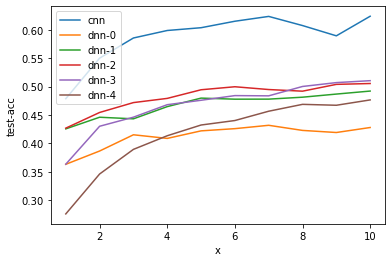

In [23]:
ax = plt.gca() 
x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,test_acc_cnn_net) 
plt.plot(x,test_acc_dnn_0) 
plt.plot(x,test_acc_dnn_1)
plt.plot(x,test_acc_dnn_2)
plt.plot(x,test_acc_dnn_3)
plt.plot(x,test_acc_dnn_4)
plt.xlabel('x')
plt.ylabel('test-acc')
plt.legend(['cnn','dnn-0','dnn-1','dnn-2','dnn-3','dnn-4'])
plt.savefig('1.png')
plt.show()

(2)Compare the accuracy achieved by rectified linear units and sigmoid units in the convolutional neural network in the code. Modify the code to use sigmoid units. Produce a graph that contains 2 curves (one for rectified linear units and another one for sigmoid units). The y-axis is the test (validation) accuracy and the x-axis is the number of epochs (# of passes through the training set). Produce curves for the first 10 epochs. Although 10 epochs is not sufficient to reach convergence, it is sufficient to see the trend. Explain the results (i.e., why did one model perform better than the other model).

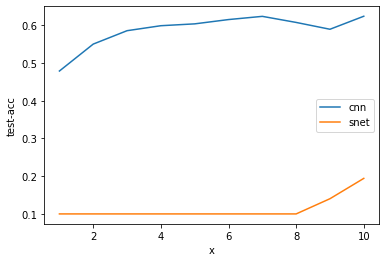

In [17]:
ax = plt.gca() 
x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,test_acc_cnn_net) 
plt.plot(x,test_acc_snet) 
plt.xlabel('x')
plt.ylabel('test-acc')
plt.legend(['cnn','snet'])
plt.savefig('2.png')
plt.show()

(3)Compare the accuracy achieved with and without drop out as well as with and without data augmentation in the convolutional neural network in the code. Modify the code in to turn on and off dropout as well as data augmentation. Produce two graphs (one for training accuracy and the other one for test accuracy) that each contain 4 curves (with and without dropout as well as with and without data augmentation). The y-axis is the accuracy (i.e., train or test/validation accuracy) and the x- axis is the number of epochs (# of passes through the training set). Produce curves for as many epochs as you can up to 100 epochs. Explain the results (i.e., why did some models perform better or worse than other models and are the results consistent with the theory). No marks will be deducted for doing less than 100 epochs, however make sure to explain what you expect to see in the curves as the number of epochs reaches 100.

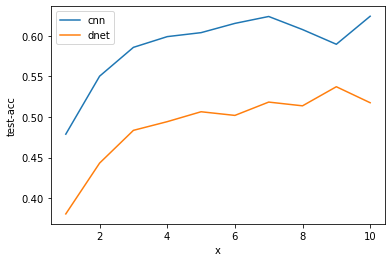

In [18]:
ax = plt.gca() 
x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,test_acc_cnn_net) 
plt.plot(x,test_acc_dnet) 
plt.xlabel('x')
plt.ylabel('test-acc')
plt.legend(['cnn','dnet'])
plt.savefig('3.png')
plt.show()

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),  # 水平翻转
     transforms.RandomGrayscale(p=0.5),  # 随机灰度
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_aug = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_aug = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
cnn_net_trained__aug, train_acc_cnn_net_aug, test_acc_cnn_net__aug = train_model(cnn_net,trainloader_aug,testloader_aug,10)

Accuracy is: 64 %
Accuracy is: 60 %
Accuracy is: 66 %
Accuracy is: 61 %
Accuracy is: 66 %
Accuracy is: 62 %
Accuracy is: 68 %
Accuracy is: 63 %
Accuracy is: 68 %
Accuracy is: 63 %
Accuracy is: 66 %
Accuracy is: 61 %
Accuracy is: 69 %
Accuracy is: 63 %
Accuracy is: 68 %
Accuracy is: 63 %
Accuracy is: 66 %
Accuracy is: 61 %
Accuracy is: 69 %
Accuracy is: 63 %
Finished Training


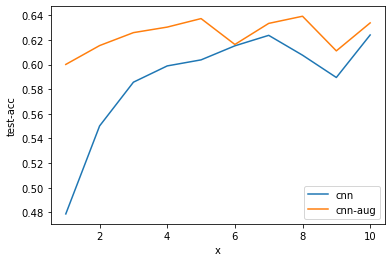

In [21]:
ax = plt.gca() 
x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,test_acc_cnn_net) 
plt.plot(x,test_acc_cnn_net__aug) 
plt.xlabel('x')
plt.ylabel('test-acc')
plt.legend(['cnn','cnn-aug'])
plt.savefig('4.png')
plt.show()